In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import time
from sklearn.preprocessing import StandardScaler

In [2]:
import regressor
import utils

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [4]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')

data = data[data.detected_bool == 1]

In [5]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [7]:
object_ids = np.unique(data.object_id)

In [8]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

In [9]:
ss = StandardScaler()

# Visual analysis

In [10]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [11]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [12]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject['log_lam'] = log_lam
    return anobject

In [13]:
def create_approx_object(anobject, n=1000):
    mjd = anobject['mjd'].values
    dfs = []
    for passband in range(6):
        df = pd.DataFrame()
        df['mjd'] = np.linspace(mjd.min(), mjd.max(), n)
        df['object_id'] = 0
        df['passband'] = passband
        df['flux'] = 0
        df['flux_err'] = 0
        df['detected_bool'] = 1
        dfs.append(df)
    new_object = pd.concat(dfs, axis=0)
    new_object = add_log_lam(new_object)
    return new_object

In [14]:
def is_good(anobject):
    good = 1
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        good = 0
    
    # keep only objects with at least 10 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 10:
            count += 1
    if count > 3:
        good = 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        good = 0
    
    return good

In [15]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)
    plt.show()

In [16]:
def scaler_transform(anobject):
    X = ss.fit_transform(anobject[['mjd', 'log_lam']].values)
    y = anobject['flux'].values
    return X, y

In [17]:
def compile_obj(t, flux, flux_err, passband):
    obj = pd.DataFrame()
    obj['mjd']      = t
    obj['flux']     = flux
    obj['flux_err'] = flux_err
    obj['passband'] = passband
    return obj

34299


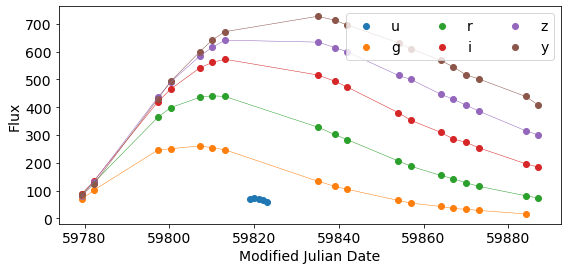

43812


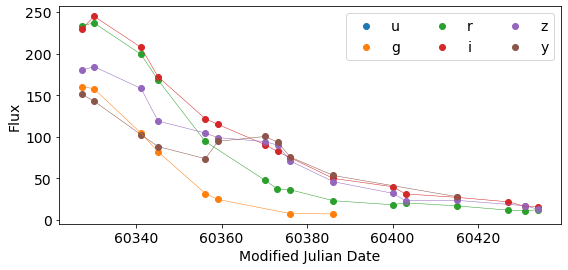

70046


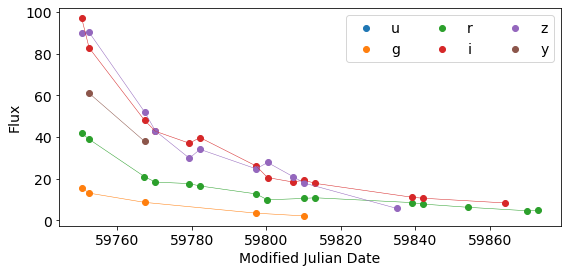

84716


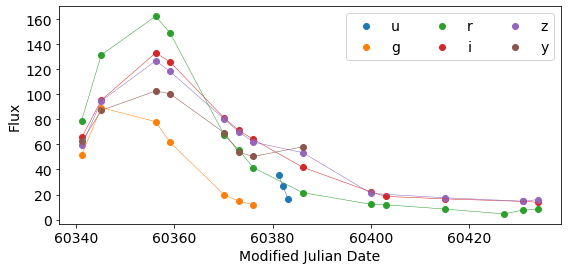

131629


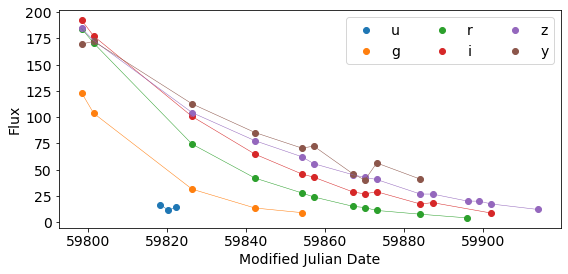

169315


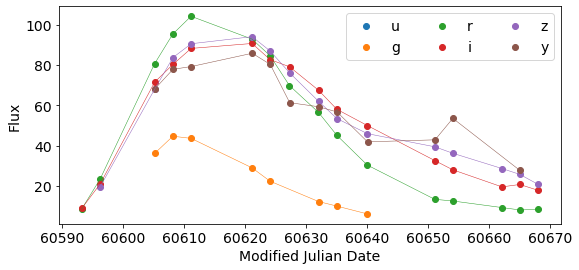

229855


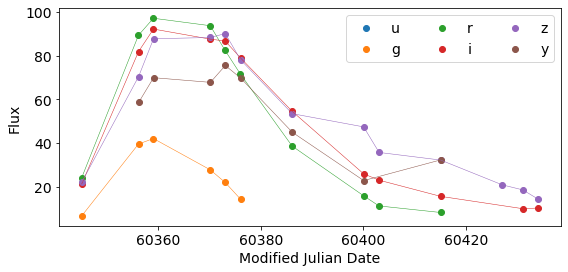

251430


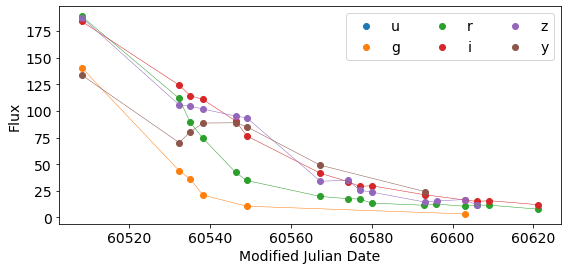

282714


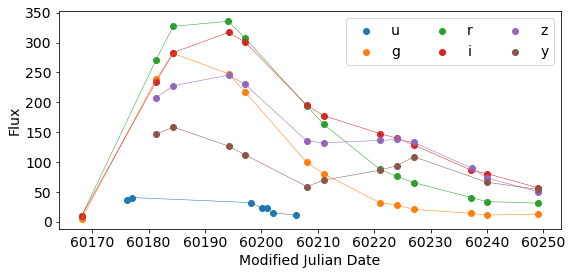

290682


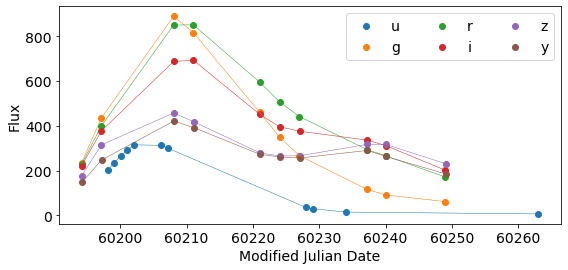

316306


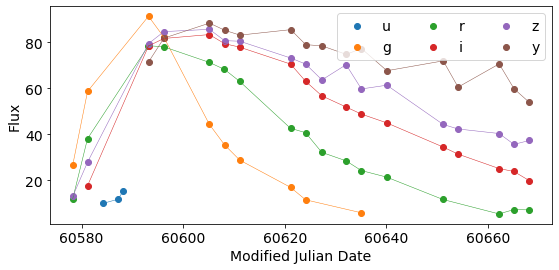

In [18]:
for i in object_ids[::50]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)

# One object test Test

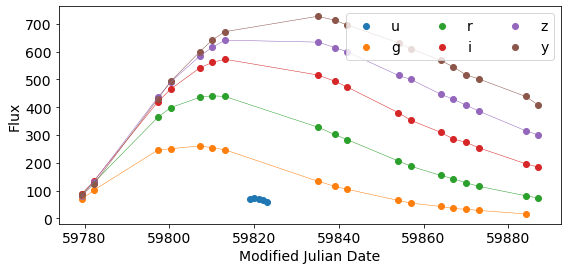

<Figure size 432x288 with 0 Axes>

In [19]:
anobject = get_object(data, 34299)
anobject = add_log_lam(anobject)

plot_light_curves(anobject)
plt.savefig('light_curve_34299.pdf', format='pdf')

In [20]:
from sklearn.model_selection import train_test_split
timer = time.time()

In [21]:
anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)

In [22]:
import NN_aug

model = NN_aug.NNProcessesAugmentation(passband2lam)
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values)

t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(anobject['mjd'].min(), anobject['mjd'].max(), 
                                                                 n_obs=1000)

In [23]:
anobject_test_pred = compile_obj(anobject_test['mjd'].values, flux_pred, 
                                 flux_err_pred, anobject_test['passband'].values)
anobject_aug = compile_obj(t_aug, flux_aug, flux_err_aug, passband_aug)

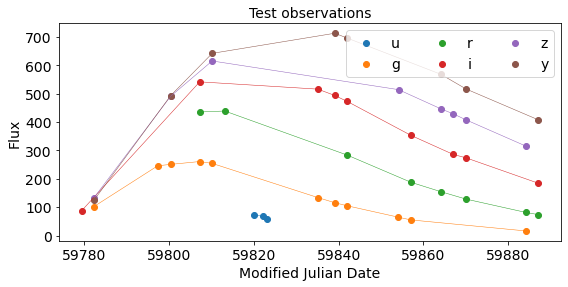

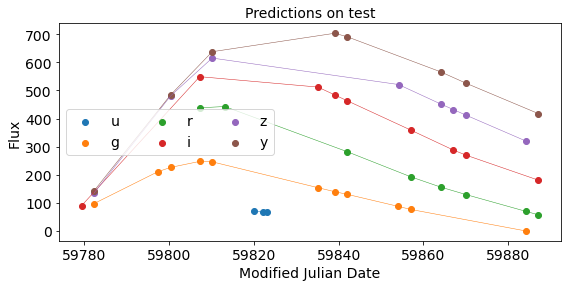

In [24]:
plot_light_curves(anobject_test, "Test observations")
plot_light_curves(anobject_test_pred, "Predictions on test")

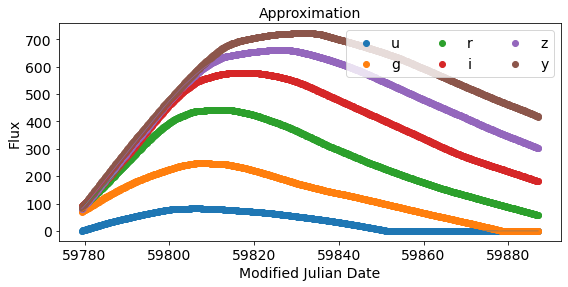

In [25]:
plot_light_curves(anobject_aug, "Approximation")

In [26]:
# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)
print("Work sec: %f" % (time.time() - timer))

RMSE:  11.99245535718362
MAE:  8.938110044854346
RSE:  0.06053133116701912
RAE:  0.05104170438853898
MAPE:  8.021080225820503
Work sec: 29.166144


In [27]:
timer = time.time()

In [28]:
X_train_ss, y_train = scaler_transform(anobject_train)

reg = regressor.FitNNRegressor(n_hidden=400, n_epochs=100, batch_size=1, lr=0.01, lam=1., optimizer='RMSprop')
reg.fit(X_train_ss, y_train)

# predict flux for unseen observations
X_test_ss = ss.transform(anobject_test[['mjd', 'log_lam']].values)
anobject_test_pred = anobject_test.copy()
anobject_test_pred['flux'] = reg.predict(X_test_ss)

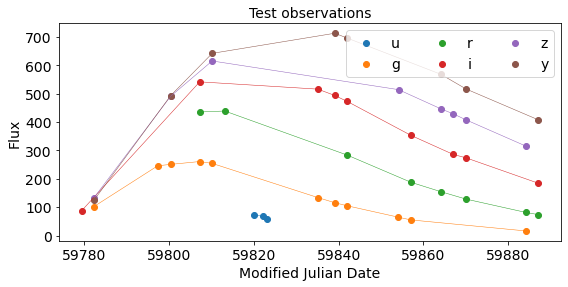

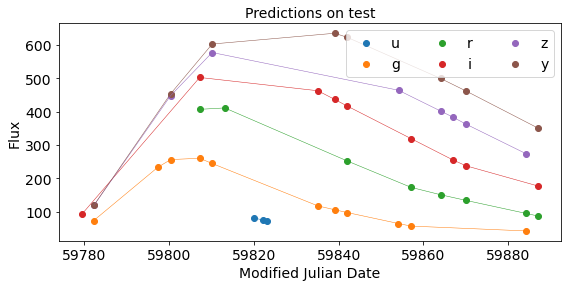

In [29]:
plot_light_curves(anobject_test, "Test observations")
plot_light_curves(anobject_test_pred, "Predictions on test")

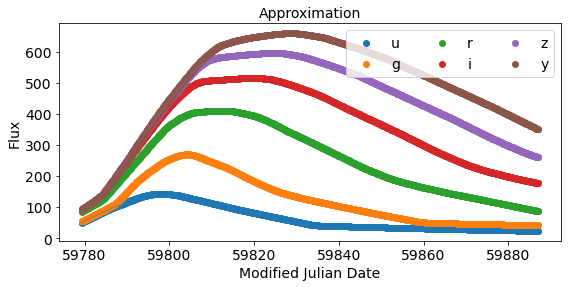

<Figure size 432x288 with 0 Axes>

In [30]:
approx_object = create_approx_object(anobject)
X = approx_object[['mjd', 'log_lam']].values
X_ss = ss.transform(X)
approx_object['flux'] = reg.predict(X_ss)
plot_light_curves(approx_object, "Approximation")
plt.savefig('approx_light_curve_34299.pdf', format='pdf')

In [31]:
# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)
print("Work sec: %f" % (time.time() - timer))

RMSE:  35.77548015062214
MAE:  28.74326786811212
RSE:  0.1805749842011499
RAE:  0.16414044740133624
MAPE:  12.673414559265487
Work sec: 14.109302


# Test on many objects

In [32]:
report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

for i in object_ids: 
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    if not is_good(anobject): continue
    
    print("Object ", i, " with ", len(anobject), " observations")
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)
    
    
    model = NN_aug.NNProcessesAugmentation(passband2lam)
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values)

    t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(anobject['mjd'].min(), anobject['mjd'].max(), n_obs=1000)
    
    anobject_test_pred = compile_obj(anobject_test['mjd'].values, flux_pred, flux_err_pred, anobject_test['passband'].values)
    
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, anobject_test_pred['flux'].values)
    report.loc[len(report), :] = [i] + list(metrics)
    

Object  745  with  61  observations
Object  1124  with  61  observations
Object  1920  with  55  observations
Object  2922  with  58  observations
Object  4173  with  77  observations
Object  4389  with  58  observations
Object  4819  with  73  observations
Object  6180  with  55  observations
Object  7033  with  72  observations
Object  7164  with  59  observations
Object  10321  with  106  observations
Object  10757  with  62  observations
Object  11359  with  80  observations
Object  11507  with  66  observations
Object  13079  with  71  observations
Object  13138  with  99  observations
Object  13194  with  61  observations
Object  13459  with  47  observations
Object  14279  with  74  observations
Object  14674  with  62  observations
Object  15002  with  58  observations
Object  15674  with  74  observations
Object  15845  with  75  observations
Object  15968  with  42  observations
Object  17370  with  90  observations
Object  18029  with  59  observations
Object  18556  with  9

In [33]:
np.round(report.mean(), 2)

ID      340898.23
RMSE        25.36
MAE         14.56
RSE          0.26
RAE          0.20
MAPE        18.36
dtype: float64

In [34]:
report

,ID,RMSE,MAE,RSE,RAE,MAPE
0,745,5.49354,4.44756,0.104945,0.120279,19.0184
1,1124,4.48898,2.52264,0.120728,0.0942469,9.44078
2,1920,20.1109,14.1614,0.325133,0.283293,32.6443
3,2922,20.818,10.0321,0.300853,0.285015,19.8102
4,4173,3.77688,2.73986,0.0761724,0.0667655,9.27036
...,...,...,...,...,...,...
511,339169,4.1257,2.8491,0.277257,0.220521,12.482
512,341653,6.339,4.91468,0.212564,0.194144,13.9895
513,342659,6.55973,4.5277,0.193047,0.162633,15.0769
514,8366012,40.948,28.717,0.335737,0.260779,35.4439
